# **Settings**

### **Packages**

In [15]:
import os
import time
import random
import platform
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# 한글 문제
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 17,8

import warnings
warnings.filterwarnings(action='ignore')

### **Fixed Random Seed**

In [2]:
import os
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

# **가중치 모델링**

## **A. 정규화된 가중치 (주원님 함수)**
**[정규화된 가중치]**
- eclo 평균 / 최대 eclo 평균

**[모델링 진행 결과]**
- 기본 params : 0.44720299227408544
- RandomizedSearchCV : 0.44712081490832284

### **가중치 데이터 생성**

In [3]:
# 파생 변수 (날짜,시간,시군구,도로형태) 생성한 원본 train data
train_preprocessed = pd.read_csv('./train_preprocessed.csv')

# 구 별 ECLO 평균값 구하기
eclo_gu = train_preprocessed.groupby('구')['ECLO'].mean().reset_index()

# 최대 eclo 평균
max_eclo_mean = eclo_gu['ECLO'].max()

# 가중치 계산
eclo_gu['가중치'] = eclo_gu['ECLO'] / max_eclo_mean

# 컬럼명 변경
eclo_gu.rename(columns={'ECLO':'eclo_mean'}, inplace=True)

In [4]:
eclo_gu

,구,eclo_mean,가중치
0,남구,4.623681,0.911559
1,달서구,4.618441,0.910526
2,달성군,5.072280,1.000000
3,동구,4.889534,0.963972
4,북구,4.687669,0.924174
5,서구,4.775680,0.941525
6,수성구,4.727300,0.931987
7,중구,4.541610,0.895378


### **가중치 원본 데이터에 적용**

In [5]:
# 파생 변수 (날짜,시간,시군구,도로형태) 생성한 원본 train/test data
train_preprocessed = pd.read_csv('./train_preprocessed.csv')
test_preprocessed = pd.read_csv('./test_preprocessed.csv')

In [6]:
# 파생 변수 (날짜,시간,시군구,도로형태) 생성한 원본 train/test 데이터에 eclo 데이터 merge

## copy
train_df = train_preprocessed.copy()
test_df = test_preprocessed.copy()

## merge 할 때 eclo 데이터의 entries 갯수가 달라서 자동 정렬됨 -> 미리 정렬 시켜놓기
train_df = train_df.sort_values(by='구') 
test_df = test_df.sort_values(by='구') 

## eclo 데이터 train/test 데이터에 merge
tr_tmp = pd.merge(train_df, eclo_gu, on='구', sort=False)
te_tmp = pd.merge(test_df, eclo_gu, on='구', sort=False)

## 불필요한 컬럼 제거 / '가중치' 컬럼 -> '구' 컬럼으로 변경 
train_merge = tr_tmp.drop(columns=['구', 'eclo_mean'])
test_merge = te_tmp.drop(columns=['구', 'eclo_mean'])
train_merge.rename(columns= {'가중치':'구'}, inplace=True)
test_merge.rename(columns= {'가중치':'구'}, inplace=True)

## train, test 컬럼 수 맞추기
train_merge = train_merge[['ID','요일','기상상태','노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구','동', '도로형태1', '도로형태2']]

## 정렬 되돌려 놓기 
train_eclo = train_merge.sort_values(by='ID')
test_eclo = test_merge.sort_values(by='ID')
train_eclo.reset_index(drop=True, inplace=True)
test_eclo.reset_index(drop=True, inplace=True)

In [7]:
display('원본 train 데이터: ', train_preprocessed)
display('구 가중치로 변경한 train 데이터: ', train_eclo)

'원본 train 데이터: '

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,...,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,...,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,...,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,...,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,...,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,52세,...,3,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,...,3,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,...,10,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,40세,...,3,2021,12,31,22,대구광역시,달서구,장동,기타,기타


'구 가중치로 변경한 train 데이터: '

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,1,0,대구광역시,0.895378,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,1,0,대구광역시,0.910526,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,0.931987,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,1,2,대구광역시,0.924174,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,1,4,대구광역시,0.963972,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,0.931987,수성동3가,교차로,교차로안
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,0.910526,상인동,단일로,기타
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,2021,12,31,21,대구광역시,0.910526,월성동,교차로,교차로안
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,2021,12,31,22,대구광역시,0.910526,장동,기타,기타


In [8]:
display('원본 test 데이터: ', test_preprocessed)
display('구 가중치로 변경한 test 데이터: ', test_eclo)

'원본 test 데이터: '

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,남구,대명동,단일로,터널
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,수성구,시지동,단일로,기타
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,연호동,단일로,기타
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,범물동,교차로,교차로부근


'구 가중치로 변경한 test 데이터: '

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,동,도로형태1,도로형태2,구
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,상동,교차로,교차로안,0.931987
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,지산동,단일로,기타,0.931987
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성동2가,교차로,교차로안,0.931987
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,신매동,단일로,기타,0.931987
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,감삼동,교차로,교차로안,0.910526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,대명동,단일로,터널,0.911559
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,시지동,단일로,기타,0.931987
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,연호동,단일로,기타,0.931987
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,범물동,교차로,교차로부근,0.931987


### **요일, 기상상태, 노면상태, 사고유형, 연, 월, 시간, 구, 도로형태1&2 로 구성 / 원핫인코딩 진행**

In [9]:
# train과 test 데이터 합치기
data_merge = pd.concat([train_eclo, test_eclo], sort=False)

# 불필요한 컬럼 제거
data_reshaped = data_merge.drop(['ID', '일', '도시', '동'], axis=1)

# 구 빼고 원핫인코딩 진행
columns_to_encode = [col for col in data_reshaped.columns if col != '구']
data_encoded = pd.get_dummies(data_reshaped, columns=columns_to_encode)
columns_to_convert = data_encoded.columns[1:]
data_encoded[columns_to_convert] = data_encoded[columns_to_convert].astype(int)

# 다시 train 과 test 세트로 분리 
train_encoded  = data_encoded[:len(train_preprocessed)]
test_encoded = data_encoded[len(train_preprocessed):]

In [10]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39609 entries, 0 to 39608
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   구                39609 non-null  float64
 1   요일_금요일           39609 non-null  int64  
 2   요일_목요일           39609 non-null  int64  
 3   요일_수요일           39609 non-null  int64  
 4   요일_월요일           39609 non-null  int64  
 5   요일_일요일           39609 non-null  int64  
 6   요일_토요일           39609 non-null  int64  
 7   요일_화요일           39609 non-null  int64  
 8   기상상태_기타          39609 non-null  int64  
 9   기상상태_눈           39609 non-null  int64  
 10  기상상태_맑음          39609 non-null  int64  
 11  기상상태_비           39609 non-null  int64  
 12  기상상태_안개          39609 non-null  int64  
 13  기상상태_흐림          39609 non-null  int64  
 14  노면상태_건조          39609 non-null  int64  
 15  노면상태_기타          39609 non-null  int64  
 16  노면상태_서리/결빙       39609 non-null  int64  
 17  노면상태_적설          

In [11]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10963 entries, 0 to 10962
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   구                10963 non-null  float64
 1   요일_금요일           10963 non-null  int64  
 2   요일_목요일           10963 non-null  int64  
 3   요일_수요일           10963 non-null  int64  
 4   요일_월요일           10963 non-null  int64  
 5   요일_일요일           10963 non-null  int64  
 6   요일_토요일           10963 non-null  int64  
 7   요일_화요일           10963 non-null  int64  
 8   기상상태_기타          10963 non-null  int64  
 9   기상상태_눈           10963 non-null  int64  
 10  기상상태_맑음          10963 non-null  int64  
 11  기상상태_비           10963 non-null  int64  
 12  기상상태_안개          10963 non-null  int64  
 13  기상상태_흐림          10963 non-null  int64  
 14  노면상태_건조          10963 non-null  int64  
 15  노면상태_기타          10963 non-null  int64  
 16  노면상태_서리/결빙       10963 non-null  int64  
 17  노면상태_적설          

### **LightGBM 모델링 진행 - 기본 params**
- 로그역변환 후 최종 RMSLE: 0.44720299227408544

In [12]:
# 데이터 준비

## eclo
eclo = train_preprocessed['ECLO']
display(eclo)

## X_train은 구 가중치 적용 및 원핫인코딩 된 train 데이터, y_train은 eclo만 뽑아낸것 
X_train = train_encoded
y_train = np.log2(eclo)

## train 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

0         5
1         3
2         3
3         5
4         3
         ..
39604     3
39605     3
39606    10
39607     3
39608     6
Name: ECLO, Length: 39609, dtype: int64

In [13]:
# LightGBM 모델 생성, 학습, 예측

## LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)  

## 기본 parameters
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


## 학습
num_round = 1000
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[train_data, val_data], early_stopping_rounds=50, verbose_eval=10)


## 예측
### 테스트 데이터 예측
lgb_predictions = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
### 테스트 데이터의 실제 값
y_true = y_valid
### 테스트 데이터의 예측 값
y_pred = lgb_predictions

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[10]	training's l2: 0.682069	valid_1's l2: 0.689879
[20]	training's l2: 0.673829	valid_1's l2: 0.685826
[30]	training's l2: 0.668798	valid_1's l2: 0.684381
[40]	training's l2: 0.665601	valid_1's l2: 0.68452
[50]	training's l2: 0.662814	valid_1's l2: 0.684424
[60]	training's l2: 0.660528	valid_1's l2: 0.684857
[70]	training's l2: 0.658366	valid_1's l2: 0.685265
[80]	training's l2: 0.656128	valid_1's l2: 0.685352
Early stopping, best iteration is:
[30]	training's l2: 0.668798	valid_1's l2: 0.684381


In [14]:
# RMSLE 평가

## RMSLE 평가 함수
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

## 로그 역변환 후 RMSLE 계산
predicted_eclo_unlog = np.exp2(lgb_predictions)
y_true_unlog = np.exp2(y_true)
lgb_rmsle = rmsle(y_true_unlog, predicted_eclo_unlog)
print("로그역변환 후 최종 RMSLE:", lgb_rmsle)

## y 실제 값 vs y 예측 값
display("y 실제 값", y_true)
print("y 예측 값", y_pred)

로그역변환 후 최종 RMSLE: 0.44720299227408544


'y 실제 값'

8707     2.321928
33104    1.584963
2992     1.584963
34752    2.000000
9708     1.584963
           ...   
14399    1.584963
32605    1.584963
33980    1.584963
23219    1.584963
2865     3.169925
Name: ECLO, Length: 7922, dtype: float64

y 예측 값 [1.79859449 2.08823243 2.01989614 ... 2.01452133 2.01808192 2.07301769]


### **LightGBM 모델링 진행 - RandomizedSearchCV**
- 로그역변환 후 최종 RMSLE: 0.44712081490832284

In [16]:
# RandomizedSearchCV 적용한 모델 생성, 학습, 예측

## LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)  



## RandomizedSearchCV
### 최적의 params 찾을 범위 설정 
param_dist = {
    'objective': ['regression'],
    'num_leaves': sp_randint(6, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'feature_fraction': [0.5, 0.7, 0.9],
    'bagging_fraction': [0.5, 0.7, 0.9],
    'bagging_freq': sp_randint(1, 10),
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'metric': ['rmse']
}

### RandomizedSearchCV 적용전 LightGBM 객체 생성
lgb_model_base = lgb.LGBMRegressor(objective='regression', verbose=0)

### RandomizedSearchCV 객체 생성 
random_search = RandomizedSearchCV(
    lgb_model_base, 
    param_distributions=param_dist, 
    n_iter=10,  
    cv=3,  # Number of cross-validation folds
    random_state=42  # Set a random seed for reproducibility
)

### RandomizedSearchCV 데이터에 학습
random_search.fit(X_train, y_train)

### 최적의 하이퍼파라미터는?
print("Best Hyperparameters:", random_search.best_params_)

### 최적의 하이퍼파라미터 적용한 모델 생성
lgb_model_RSCV = random_search.best_estimator_



## 예측
### 테스트 데이터 예측 
lgb_predictions_RSCV = lgb_model_RSCV.predict(X_valid)
### 테스트 데이터의 실제 값
y_true = y_valid
### 테스트 데이터의 예측 값
y_pred_RSCV = lgb_predictions_RSCV

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

Best Hyperparameters: {'bagging_fraction': 0.9, 'bagging_freq': 7, 'boosting_type': 'gbdt', 'feature_fraction': 0.5, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 23, 'objective': 'regression'}

In [17]:
# RMSLE 평가

## RMSLE 평가 함수
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

## 로그 역변환 후 RMSLE 계산
predicted_eclo_unlog = np.exp2(lgb_predictions_RSCV)
y_true_unlog = np.exp2(y_true)
lgb_rmsle = rmsle(y_true_unlog, predicted_eclo_unlog)
print("로그역변환 후 최종 RMSLE:", lgb_rmsle)

## y 실제 값 vs y 예측 값
display("y 실제 값", y_true)
print("y 예측 값", y_pred_RSCV)

로그역변환 후 최종 RMSLE: 0.44712081490832284


'y 실제 값'

8707     2.321928
33104    1.584963
2992     1.584963
34752    2.000000
9708     1.584963
           ...   
14399    1.584963
32605    1.584963
33980    1.584963
23219    1.584963
2865     3.169925
Name: ECLO, Length: 7922, dtype: float64

y 예측 값 [1.76199458 2.07790591 2.03959849 ... 2.00833171 2.0336057  2.08152597]


## **B. 시각화분석 가중치**
**[사고건수 대비 ECLO 평균값이 높은 순 (10점 만점)]**
1. 달성군 : 4.5
2. 동구-서구 : 2.5
3. 북구-수성구 : 1.5
4. 남구-중구 : 1
5. 달서구 : 0.5

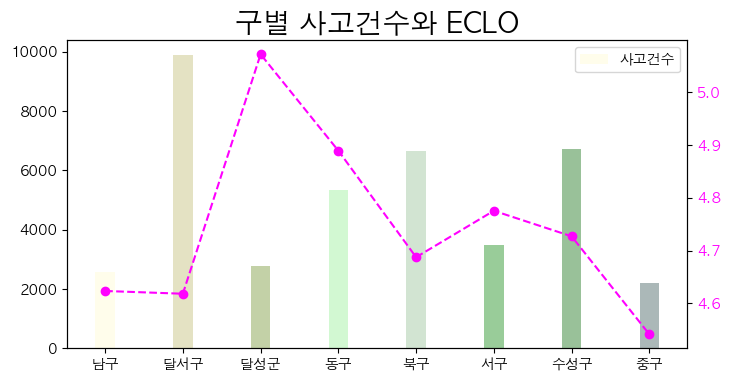


**[모델링 진행 결과]**
- 기본 params : 0.44720941512496004
- RandomizedSearchCV : 0.44729510828392993

### **시각화 분석**

In [35]:
tmp = train_preprocessed[['구', 'ECLO']]
tmp2 = tmp.groupby('구')['ECLO'].mean()
gu_eda = pd.DataFrame(tmp2)
gu_eda['사고건수'] = train_preprocessed['구'].value_counts()
gu_eda

,ECLO,사고건수
구,,
남구,4.623681,2559
달서구,4.618441,9891
달성군,5.072280,2767
동구,4.889534,5341
북구,4.687669,6650
서구,4.775680,3495
수성구,4.727300,6707
중구,4.541610,2199


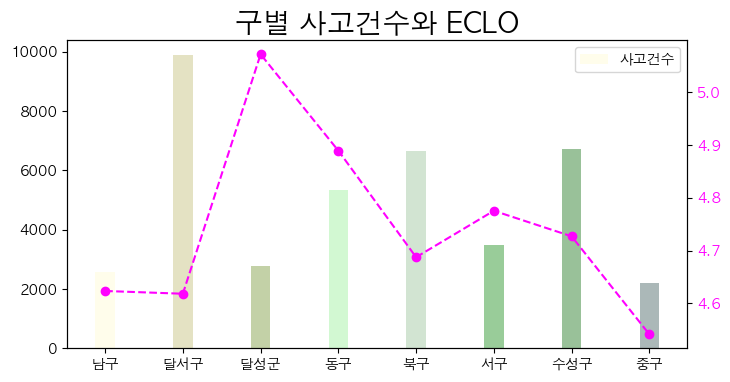

In [39]:
# 시각화

## figure setting
fig = plt.figure(figsize=(8,4))
bar_width = 0.25
fig.set_facecolor('white')

## multi-bar graph
N = 8
ind = np.arange(N)
gu = ('남구', '달서구', '달성군', '동구', '북구', '서구', '수성구', '중구')
colors = ['lemonchiffon', 'darkkhaki', 'olivedrab', 'lightgreen', 'darkseagreen', 'green', 'darkgreen', 'darkslategray']
ax1 = fig.add_subplot()
xtick_label_position = ind
ax1.set_xticks(xtick_label_position)
ax1.set_xticklabels(gu)
ax1.bar(ind, gu_eda['사고건수'], bar_width, alpha=0.4, color=colors, label='사고건수')
ax1.legend()

## line graph
eclo = gu_eda['ECLO']
color = ('magenta')
ax2 = ax1.twinx()
ax2.plot(xtick_label_position, eclo, color=color, linestyle='--', marker="o")
ax2.tick_params(axis='y', labelcolor=color)

plt.title('구별 사고건수와 ECLO', fontsize=20)
plt.show()

### **가중치 데이터 생성**

In [18]:
weights = {'구': ['달성군', '동구', '서구', '북구', '수성구', '남구', '중구', '달서구'],
        '가중치': [4.5, 2.5, 2.5, 1.5, 1.5, 1, 1, 0.5]}

weight_df = pd.DataFrame(weights)

display(weight_df)

,구,가중치
0,달성군,4.5
1,동구,2.5
2,서구,2.5
3,북구,1.5
4,수성구,1.5
5,남구,1.0
6,중구,1.0
7,달서구,0.5


### **가중치 원본 데이터에 적용**

In [19]:
# 파생 변수 (날짜,시간,시군구,도로형태) 생성한 원본 train/test data
train_preprocessed = pd.read_csv('./train_preprocessed.csv')
test_preprocessed = pd.read_csv('./test_preprocessed.csv')

In [20]:
# 파생 변수 (날짜,시간,시군구,도로형태) 생성한 원본 train/test 데이터에 eclo 데이터 merge

## copy
train_df = train_preprocessed.copy()
test_df = test_preprocessed.copy()

## merge 할 때 eclo 데이터의 entries 갯수가 달라서 자동 정렬됨 -> 미리 정렬 시켜놓기
train_df = train_df.sort_values(by='구') 
test_df = test_df.sort_values(by='구') 

## eclo 데이터 train/test 데이터에 merge
tr_tmp = pd.merge(train_df, weight_df, on='구', sort=False)
te_tmp = pd.merge(test_df, weight_df, on='구', sort=False)

In [22]:
## 기존 '구' 컬럼 제거 / '가중치' 컬럼 -> '구' 컬럼으로 변경 
train_merge = tr_tmp.drop(columns=['구'])
test_merge = te_tmp.drop(columns=['구'])
train_merge.rename(columns= {'가중치':'구'}, inplace=True)
test_merge.rename(columns= {'가중치':'구'}, inplace=True)

## train, test 컬럼 수 맞추기
train_merge = train_merge[['ID','요일','기상상태','노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구','동', '도로형태1', '도로형태2']]

## 정렬 되돌려 놓기 
train_eclo = train_merge.sort_values(by='ID')
test_eclo = test_merge.sort_values(by='ID')
train_eclo.reset_index(drop=True, inplace=True)
test_eclo.reset_index(drop=True, inplace=True)

In [23]:
display('원본 train 데이터: ', train_preprocessed)
display('구 가중치로 변경한 train 데이터: ', train_eclo)

'원본 train 데이터: '

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,...,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,...,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,...,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,...,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,...,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,52세,...,3,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,...,3,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,...,10,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,40세,...,3,2021,12,31,22,대구광역시,달서구,장동,기타,기타


'구 가중치로 변경한 train 데이터: '

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,1,0,대구광역시,1.0,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,1,0,대구광역시,0.5,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,1.5,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,1,2,대구광역시,1.5,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,1,4,대구광역시,2.5,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,1.5,수성동3가,교차로,교차로안
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,0.5,상인동,단일로,기타
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,2021,12,31,21,대구광역시,0.5,월성동,교차로,교차로안
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,2021,12,31,22,대구광역시,0.5,장동,기타,기타


In [24]:
display('원본 test 데이터: ', test_preprocessed)
display('구 가중치로 변경한 test 데이터: ', test_eclo)

'원본 test 데이터: '

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,남구,대명동,단일로,터널
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,수성구,시지동,단일로,기타
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,연호동,단일로,기타
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,범물동,교차로,교차로부근


'구 가중치로 변경한 test 데이터: '

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,동,도로형태1,도로형태2,구
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,상동,교차로,교차로안,1.5
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,지산동,단일로,기타,1.5
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성동2가,교차로,교차로안,1.5
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,신매동,단일로,기타,1.5
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,감삼동,교차로,교차로안,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,대명동,단일로,터널,1.0
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,시지동,단일로,기타,1.5
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,연호동,단일로,기타,1.5
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,범물동,교차로,교차로부근,1.5


### **요일, 기상상태, 노면상태, 사고유형, 연, 월, 시간, 구, 도로형태1&2 로 구성 / 원핫인코딩 진행**

In [25]:
# train과 test 데이터 합치기
data_merge = pd.concat([train_eclo, test_eclo], sort=False)

# 불필요한 컬럼 제거
data_reshaped = data_merge.drop(['ID', '일', '도시', '동'], axis=1)

# 구 빼고 원핫인코딩 진행
columns_to_encode = [col for col in data_reshaped.columns if col != '구']
data_encoded = pd.get_dummies(data_reshaped, columns=columns_to_encode)
columns_to_convert = data_encoded.columns[1:]
data_encoded[columns_to_convert] = data_encoded[columns_to_convert].astype(int)

# 다시 train 과 test 세트로 분리 
train_encoded  = data_encoded[:len(train_preprocessed)]
test_encoded = data_encoded[len(train_preprocessed):]

In [26]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39609 entries, 0 to 39608
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   구                39609 non-null  float64
 1   요일_금요일           39609 non-null  int64  
 2   요일_목요일           39609 non-null  int64  
 3   요일_수요일           39609 non-null  int64  
 4   요일_월요일           39609 non-null  int64  
 5   요일_일요일           39609 non-null  int64  
 6   요일_토요일           39609 non-null  int64  
 7   요일_화요일           39609 non-null  int64  
 8   기상상태_기타          39609 non-null  int64  
 9   기상상태_눈           39609 non-null  int64  
 10  기상상태_맑음          39609 non-null  int64  
 11  기상상태_비           39609 non-null  int64  
 12  기상상태_안개          39609 non-null  int64  
 13  기상상태_흐림          39609 non-null  int64  
 14  노면상태_건조          39609 non-null  int64  
 15  노면상태_기타          39609 non-null  int64  
 16  노면상태_서리/결빙       39609 non-null  int64  
 17  노면상태_적설          

In [27]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10963 entries, 0 to 10962
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   구                10963 non-null  float64
 1   요일_금요일           10963 non-null  int64  
 2   요일_목요일           10963 non-null  int64  
 3   요일_수요일           10963 non-null  int64  
 4   요일_월요일           10963 non-null  int64  
 5   요일_일요일           10963 non-null  int64  
 6   요일_토요일           10963 non-null  int64  
 7   요일_화요일           10963 non-null  int64  
 8   기상상태_기타          10963 non-null  int64  
 9   기상상태_눈           10963 non-null  int64  
 10  기상상태_맑음          10963 non-null  int64  
 11  기상상태_비           10963 non-null  int64  
 12  기상상태_안개          10963 non-null  int64  
 13  기상상태_흐림          10963 non-null  int64  
 14  노면상태_건조          10963 non-null  int64  
 15  노면상태_기타          10963 non-null  int64  
 16  노면상태_서리/결빙       10963 non-null  int64  
 17  노면상태_적설          

### **LightGBM 모델링 진행 - 기본 params**
- 로그역변환 후 최종 RMSLE: 0.44720941512496004

In [29]:
# 데이터 준비

## eclo
eclo = train_preprocessed['ECLO']
display(eclo)

## X_train은 구 가중치 적용 및 원핫인코딩 된 train 데이터, y_train은 eclo만 뽑아낸것 
X_train = train_encoded
y_train = np.log2(eclo)

## train 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

0         5
1         3
2         3
3         5
4         3
         ..
39604     3
39605     3
39606    10
39607     3
39608     6
Name: ECLO, Length: 39609, dtype: int64

In [30]:
# LightGBM 모델 생성, 학습, 예측

## LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)  

## 기본 parameters
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


## 학습
num_round = 1000
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[train_data, val_data], early_stopping_rounds=50, verbose_eval=10)


## 예측
### 테스트 데이터 예측
lgb_predictions = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
### 테스트 데이터의 실제 값
y_true = y_valid
### 테스트 데이터의 예측 값
y_pred = lgb_predictions

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[10]	training's l2: 0.682091	valid_1's l2: 0.690013
[20]	training's l2: 0.673931	valid_1's l2: 0.686288
[30]	training's l2: 0.669166	valid_1's l2: 0.684855
[40]	training's l2: 0.666067	valid_1's l2: 0.684761
[50]	training's l2: 0.663342	valid_1's l2: 0.684594
[60]	training's l2: 0.661123	valid_1's l2: 0.684901
[70]	training's l2: 0.658957	valid_1's l2: 0.685308
[80]	training's l2: 0.656787	valid_1's l2: 0.686051
[90]	training's l2: 0.654759	valid_1's l2: 0.686323
Early stopping, best iteration is:
[44]	training's l2: 0.664906	valid_1's l2: 0.68451


In [31]:
# RMSLE 평가

## RMSLE 평가 함수
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

## 로그 역변환 후 RMSLE 계산
predicted_eclo_unlog = np.exp2(lgb_predictions)
y_true_unlog = np.exp2(y_true)
lgb_rmsle = rmsle(y_true_unlog, predicted_eclo_unlog)
print("로그역변환 후 최종 RMSLE:", lgb_rmsle)

## y 실제 값 vs y 예측 값
display("y 실제 값", y_true)
print("y 예측 값", y_pred)

로그역변환 후 최종 RMSLE: 0.44720941512496004


'y 실제 값'

8707     2.321928
33104    1.584963
2992     1.584963
34752    2.000000
9708     1.584963
           ...   
14399    1.584963
32605    1.584963
33980    1.584963
23219    1.584963
2865     3.169925
Name: ECLO, Length: 7922, dtype: float64

y 예측 값 [1.77609916 2.06099744 2.01464267 ... 2.01336117 2.0241741  2.10261467]


### **LightGBM 모델링 진행 - RandomizedSearchCV**
- 로그역변환 후 최종 RMSLE: 0.44729510828392993

In [32]:
# RandomizedSearchCV 적용한 모델 생성, 학습, 예측

## LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)  



## RandomizedSearchCV
### 최적의 params 찾을 범위 설정 
param_dist = {
    'objective': ['regression'],
    'num_leaves': sp_randint(6, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'feature_fraction': [0.5, 0.7, 0.9],
    'bagging_fraction': [0.5, 0.7, 0.9],
    'bagging_freq': sp_randint(1, 10),
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'metric': ['rmse']
}

### RandomizedSearchCV 적용전 LightGBM 객체 생성
lgb_model_base = lgb.LGBMRegressor(objective='regression', verbose=0)

### RandomizedSearchCV 객체 생성 
random_search = RandomizedSearchCV(
    lgb_model_base, 
    param_distributions=param_dist, 
    n_iter=10,  
    cv=3,  # Number of cross-validation folds
    random_state=42  # Set a random seed for reproducibility
)

### RandomizedSearchCV 데이터에 학습
random_search.fit(X_train, y_train)

### 최적의 하이퍼파라미터는?
print("Best Hyperparameters:", random_search.best_params_)

### 최적의 하이퍼파라미터 적용한 모델 생성
lgb_model_RSCV = random_search.best_estimator_



## 예측
### 테스트 데이터 예측 
lgb_predictions_RSCV = lgb_model_RSCV.predict(X_valid)
### 테스트 데이터의 실제 값
y_true = y_valid
### 테스트 데이터의 예측 값
y_pred_RSCV = lgb_predictions_RSCV

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

In [33]:
# RMSLE 평가

## RMSLE 평가 함수
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

## 로그 역변환 후 RMSLE 계산
predicted_eclo_unlog = np.exp2(lgb_predictions_RSCV)
y_true_unlog = np.exp2(y_true)
lgb_rmsle = rmsle(y_true_unlog, predicted_eclo_unlog)
print("로그역변환 후 최종 RMSLE:", lgb_rmsle)

## y 실제 값 vs y 예측 값
display("y 실제 값", y_true)
print("y 예측 값", y_pred_RSCV)

로그역변환 후 최종 RMSLE: 0.44729510828392993


'y 실제 값'

8707     2.321928
33104    1.584963
2992     1.584963
34752    2.000000
9708     1.584963
           ...   
14399    1.584963
32605    1.584963
33980    1.584963
23219    1.584963
2865     3.169925
Name: ECLO, Length: 7922, dtype: float64

y 예측 값 [1.75237613 2.08190452 2.04105164 ... 2.01640203 2.02456738 2.07955657]
